# Profiling Time and Memory Cost

This tutorial explains how to profile cpu and memory usage with the `evokit.watch` module. Reading the [Watcher tutorial](./watch.ipynb) is helpful but not required: as watchers are designed to be easy to use, you do not need to know how they work to use them.

The `evokit.watch` module comes with several stock watchers. This tutorial will discuss the following:

* All members of evokit.watch.watchers, such as `fitness_watcher`.

* Members of evokit.watch.watchers, in particular `MemoryWatcher` and `AttributeMemoryWatcher`.

You might have noticed that `evokit.watch` includes both snake case factory functions (e.g. `fitness_watcher`) and camel case classes (e.g. `MemoryWatcher`). As a rule, watchers that can be implemented by directly instantiating `Watcher` with a custom handler are implemented as functions; those that require modifying class members are implemented as child classes.

Last but not least, _be warned that memory profiling can be expensive_. Running this tutorial yourself can take time; please consider reducing the number of metrics collected or increasing the `stride`.

In [1]:
from evokit.watch.watchers import create_fitness_watcher
from evokit.watch.watchers import create_cpu_watcher
from evokit.watch.watchers import create_rss_watcher
from evokit.watch.watchers import create_size_watcher
from evokit.watch.memory import MemoryWatcher, MemoryWatcherMetric
from evokit.watch.memory import AttributeMemoryWatcher
from typing import Callable
import inspect

## Simple Metrics

The `.watch.watcher` module contains several lightweight factory functions. These are lightweight, in that you can create them by directly instantiating a `Watcher`. Let's take `create_fitness_watcher` as an example:

In [2]:
def get_handler(factory: Callable):
    source_lines: list[str] = inspect.getsource(create_fitness_watcher).split("\n")
    for i in range(len(source_lines)):
        if  "handler=" in source_lines[i]:
            return "...\n" + "\n".join(source_lines[i-1:i+2]) + "\n..."
    
print(get_handler(create_fitness_watcher))


...
        stride=stride,
        handler=lambda x: x.population.best().fitness,
        watch_post_step=watch_post_step,
...


As you see in the cell above, all `create_fitness_watcher` does is to create a `Watcher` with its `handler` set to `x.population.best().fitness`.

Knowing this, let's continue with experimenting the following watchers:

| Method                   | Return Type        |
| ------------------------ | ------------------ |
| `create_fitness_watcher` | `tuple[int, ...]`  |
| `create_size_watcher`    | `int`              |
| `create_cpu_watcher`     | `float`            |
| `create_rss_watcher`     | `float`            |


In [3]:
from evokit.watch.watchers import create_fitness_watcher
from evokit.watch.watchers import create_cpu_watcher
from evokit.watch.watchers import create_rss_watcher
from evokit.watch.watchers import create_size_watcher
import time

WATCHER_TIMER: Callable[[], float] = time.perf_counter

In [4]:
MUTATION_P: float = 0.02
STEP_COUNT: int = 60
POP_SIZE: int = 1000
IND_SIZE: int = 10000

from evokit.evolvables.prefabs import make_onemax

In [5]:
algo = make_onemax(POP_SIZE,
                   IND_SIZE,
                   MUTATION_P,
                   max_parents=0)

default_watcher_settings = {
    "events": algo.events,
    "watch_post_step":True,
    "timer": WATCHER_TIMER
}

fitness_watcher = create_fitness_watcher(**default_watcher_settings)
size_watcher = create_size_watcher(**default_watcher_settings)
cpu_watcher = create_cpu_watcher(**default_watcher_settings)
rss_watcher = create_rss_watcher(**default_watcher_settings)
algo.register(fitness_watcher, size_watcher, cpu_watcher, rss_watcher)

In [6]:
for _ in range(STEP_COUNT):
    algo.step()

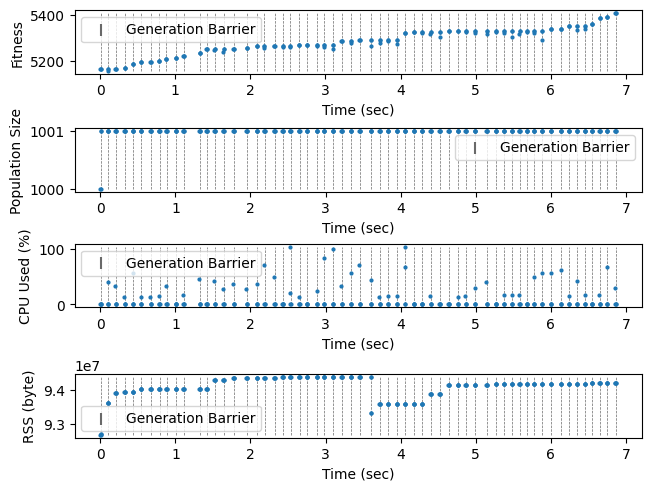

In [7]:
import matplotlib.pyplot as plt
from evokit.watch.visual import plot
_, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,
                                       ncols=1,
                                       layout='constrained')

plot(fitness_watcher, axes=ax1, show_generation=True, s=4)
ax1.set_ylabel("Fitness")
plot(size_watcher, axes=ax2, show_generation=True, s=4)
ax2.set_ylabel("Population Size")
plot(cpu_watcher, axes=ax3, show_generation=True, s=4)
ax3.set_ylabel("CPU Used (%)")
plot(rss_watcher, axes=ax4, show_generation=True, s=4)
ax4.set_ylabel("RSS (byte)")
plt.show()

### Profile Experiment with Lineage Tracing

Having these profiling tools allows us to investigate the behaviour of algorithms. Consider, for example, an OEE algorithm that preserves the 20 most recent parents of each individual -- we would like to see how much resources this algorithm takes compares to the previous one.

The following cell reruns the experiment, except with `max_parents=20` set to 20 for `make_onemax`.

In [8]:
algo = make_onemax(POP_SIZE,
                   IND_SIZE,
                   MUTATION_P,
                   max_parents=20)

default_watcher_settings = {
    "events": algo.events,
    "watch_post_step":True,
    "timer": WATCHER_TIMER
}

fitness_watcher = create_fitness_watcher(**default_watcher_settings)
size_watcher = create_size_watcher(**default_watcher_settings)
cpu_watcher = create_cpu_watcher(**default_watcher_settings)
rss_watcher = create_rss_watcher(**default_watcher_settings)
algo.register(fitness_watcher, size_watcher, cpu_watcher, rss_watcher)

for _ in range(STEP_COUNT):
    algo.step()

In the following plot, we see that while the algorithm takes about the same amount of time to run, it takes substantially more memory -- to be specific, the cost starts at two entire generations at the beginning, increases by one generation after each step (because parents are preserved instead of discarded), until the 20th generation where the oldest parents start to be expunged. This behaviour is expected.

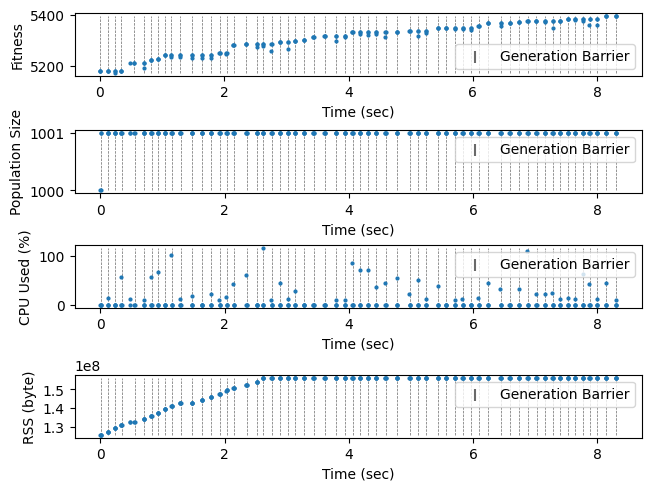

In [9]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,
                                       ncols=1,
                                       layout='constrained')
plot(fitness_watcher, axes=ax1, show_generation=True, s=4)
ax1.set_ylabel("Fitness")
plot(size_watcher, axes=ax2, show_generation=True, s=4)
ax2.set_ylabel("Population Size")
plot(cpu_watcher, axes=ax3, show_generation=True, s=4)
ax3.set_ylabel("CPU Used (%)")
plot(rss_watcher, axes=ax4, show_generation=True, s=4)
ax4.set_ylabel("RSS (byte)")
plt.show()

### Profile Experiment with Multiprocessing

For one final example, consider an algorithm that parallelises both the evaluator and the selector. This is horribly inefficient for OneMax: since parallelising a task requires completely serialising and de-serialising individuals, it is best suited for simulation tasks that take seconds or minutes to run.

For efficiency, let's cut the population size by 200. The algorithm should be quite slow even then.

In [13]:
algo = make_onemax(int(POP_SIZE / 200),
                   IND_SIZE,
                   MUTATION_P,
                   variator_processes=5,
                   evaluator_processes=5,
                   max_parents=20)

default_watcher_settings = {
    "events": algo.events,
    "watch_post_step":True,
    "timer": WATCHER_TIMER
}

fitness_watcher = create_fitness_watcher(**default_watcher_settings)
size_watcher = create_size_watcher(**default_watcher_settings)
cpu_watcher = create_cpu_watcher(**default_watcher_settings)
rss_watcher = create_rss_watcher(**default_watcher_settings)
algo.register(fitness_watcher, size_watcher, cpu_watcher, rss_watcher)

for _ in range(STEP_COUNT):
    algo.step()

The plot shows that the algorithm indeed optimise, albeit at a much slower rate. CPU and memory usages are acceptable even accounting for the increased runtime.

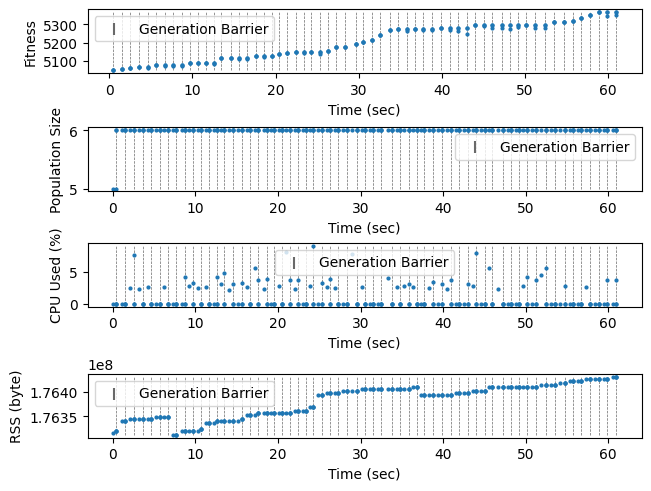

In [14]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,
                                       ncols=1,
                                       layout='constrained')

plot(fitness_watcher, axes=ax1, show_generation=True, s=4)
ax1.set_ylabel("Fitness")
plot(size_watcher, axes=ax2, show_generation=True, s=4)
ax2.set_ylabel("Population Size")
plot(cpu_watcher, axes=ax3, show_generation=True, s=4)
ax3.set_ylabel("CPU Used (%)")
plot(rss_watcher, axes=ax4, show_generation=True, s=4)
ax4.set_ylabel("RSS (byte)")
plt.show()